# Bagian B: Task 3

Script config:

In [31]:
RANDOM_STATE = 42
FRAUD_DATA_PATH = '../data/fraud.xlsx'

## Import Library and Data

### Summary of Library Used
- **Pandas**: Digunakan untuk manipulasi dan analisis data.
- **NumPy**: Digunakan untuk operasi numerik.
- **XGBoost**: Digunakan untuk membangun model machine learning.
- **Scikit-learn**: Digunakan untuk membagi data latih dan uji, serta evaluasi model
- **Geopy**: Digunakan untuk menghitung jarak antara lokasi penjual dan pembeli berdasarkan fitur spasial.
- **SHAP**: Digunakan untuk interpretasi model XGBoost dan pemilihan fitur.


In [ ]:

# Mengimpor library yang dibutuhkan untuk analisis data, pemodelan, dan interpretasi

import pandas as pd  # Library untuk manipulasi dan analisis data
from geopy.distance import geodesic  # Menghitung jarak geografis antara dua titik
import numpy as np  # Library untuk operasi numerik

from sklearn.model_selection import train_test_split  # Membagi dataset menjadi data latih dan uji
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb  # Library XGBoost untuk pemodelan machine learning
import shap  # Library untuk interpretasi model dan analisis pentingnya fitur


## Data Cleaning and Preprocessing

### Summary of Data Cleaning Step
1. Merubah variabel **trans_date_trans_time** ke bentuk datetime
2. Merubah variabel **dob** ke bentuk datetime
3. Memodifikasi variabel **is_fraud** karena ada yang bercampur dengan tanggal lalu merubah tipenya menjadi pd.categorical
4. Membersihkan variabel **merchant** karena ada yang terkontaminasi karakter string (") dengan regex lalu merubah tipenya menjadi pd.categorical
5. Membersihkan variabel **job** karena ada yang terkontaminasi karakter string (") dengan regex lalu merubah tipenya menjadi pd.categorical
6. Merubah variabel **category** menjadi pd.categorical
7. Merubah variabel **city** menjadi pd.categorical
8. Merubah variabel **state** menjadi pd.categorical
9. Merubah variabel **trans_num** menjadi pd.categorical

In [55]:
# Membaca data dari FRAUD_DATA_PATH dan menghapus data duplikat berdasarkan 'trans_num'
data = pd.read_excel(FRAUD_DATA_PATH)
data = data.drop_duplicates(subset='trans_num', keep='first')  # Hapus duplikat, simpan hanya yang pertama

# Mengubah kolom waktu transaksi dan tanggal lahir menjadi tipe datetime
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])  # Ubah tipe data 'trans_date_trans_time' ke datetime
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')  # Ubah tipe data 'dob' ke datetime, gunakan 'coerce' untuk menangani kesalahan
data = data.sort_values(by='trans_date_trans_time')  # Urutkan data berdasarkan waktu transaksi

# Mengubah beberapa kolom menjadi tipe kategori untuk optimasi memori dan analisis kategorikal
data['is_fraud'] = data['is_fraud'].astype(str) \
                   .str.replace('1"2020-12-24 16:56:24"', '1') \
                   .replace('0"2019-01-01 00:00:44"', '0') \
                   .astype('category')  # Bersihkan dan ubah tipe data 'is_fraud' ke kategori

data['merchant'] = data['merchant'].str.replace(r'^"|"$', '', regex=True).astype('category')  # Hapus tanda kutip dan ubah ke kategori
data['job'] = data['job'].str.replace(r'^"|"$', '', regex=True).astype('category')  # Hapus tanda kutip dan ubah ke kategori
data['category'] = data['category'].astype('category')  # Ubah ke tipe kategori
data['city'] = data['city'].astype('category')  # Ubah ke tipe kategori
data['state'] = data['state'].astype('category')  # Ubah ke tipe kategori
data['trans_num'] = data['trans_num'].astype('category')  # Ubah ke tipe kategori

# Menampilkan informasi dataset setelah pemrosesan tipe data
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14383 entries, 7781 to 7779
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  14383 non-null  datetime64[ns]
 1   merchant               14383 non-null  category      
 2   category               14383 non-null  category      
 3   amt                    14383 non-null  float64       
 4   city                   14383 non-null  category      
 5   state                  14383 non-null  category      
 6   lat                    14383 non-null  float64       
 7   long                   14383 non-null  float64       
 8   city_pop               14383 non-null  int64         
 9   job                    14383 non-null  category      
 10  dob                    14383 non-null  datetime64[ns]
 11  trans_num              14383 non-null  category      
 12  merch_lat              14383 non-null  float64       
 13  merc

## Feature Engineering

### Summary of Feature Engineering

1. **Menghapus Kolom yang Tidak Diperlukan**  
   - Kolom `trans_num` dihapus dari dataset karena tidak relevan untuk pemodelan.
   - Kolom target `is_fraud` dipisahkan ke dalam variabel `y` sebagai label data.

2. **Ekstraksi Fitur dari Tanggal dan Waktu Transaksi**
   - Beberapa fitur kategorikal diturunkan dari kolom `trans_date_trans_time`:
     - `trans_year`: Tahun transaksi (kategori).
     - `trans_month`: Bulan transaksi (kategori).
     - `trans_day_of_month`: Hari dalam bulan dari transaksi (kategori).
     - `trans_day_of_week`: Hari dalam minggu dari transaksi (kategori).
     - `trans_day_of_year`: Hari dalam tahun dari transaksi (kategori).
     - `trans_hour`: Jam transaksi (kategori).

3. **Konversi Waktu Transaksi ke Detik**
   - `trans_time_to_second`: Jumlah total detik dari waktu transaksi (jam, menit, detik) untuk memfasilitasi transformasi sirkular.

4. **Perhitungan Usia Pelanggan**
   - `cust_age`: Usia pelanggan dalam tahun pada saat transaksi, dihitung dari selisih antara tanggal transaksi dengan tanggal lahir (`dob`).

5. **Transformasi Sirkular untuk Waktu Transaksi**
   - Fitur sirkular `trans_time_sin` dan `trans_time_cos` dibuat untuk menangkap pola siklus pada waktu transaksi (misalnya, untuk membedakan pagi dan malam hari).

6. **Perhitungan Jarak Geografis**
   - `distance`: Jarak geografis (dalam meter) antara lokasi pelanggan (`lat`, `long`) dan lokasi merchant (`merch_lat`, `merch_long`) menggunakan formula jarak geodesik.

7. **Menghapus Kolom yang Tidak Dibutuhkan**
   - Kolom-kolom yang telah digunakan dalam rekayasa fitur atau yang tidak relevan untuk pemodelan, seperti lokasi dan tanggal (`merch_lat`, `merch_long`, `lat`, `long`, `trans_date_trans_time`, `dob`), dihapus untuk mengurangi dimensi data dan memastikan input yang lebih bersih bagi model.

8. **Pemeriksaan Informasi Dataset**
   - `X.info()` menampilkan ringkasan dari dataset akhir, termasuk tipe data dan jumlah kolom, untuk tinjauan akhir sebelum pemodelan.


In [56]:
# Drop kolom 'trans_num' dan pisahkan kolom target 'is_fraud' ke dalam variabel y
X = data.drop(columns=['trans_num'])
y = data['is_fraud']

# Ekstraksi fitur dari kolom waktu transaksi menjadi kategori
X['trans_year'] = X['trans_date_trans_time'].dt.year.astype('category')            # Tahun transaksi
X['trans_month'] = X['trans_date_trans_time'].dt.month.astype('category')          # Bulan transaksi
X['trans_day_of_month'] = X['trans_date_trans_time'].dt.day.astype('category')     # Hari dalam bulan
X['trans_day_of_week'] = X['trans_date_trans_time'].dt.day_of_week.astype('category')  # Hari dalam minggu
X['trans_day_of_year'] = X['trans_date_trans_time'].dt.day_of_year.astype('category')  # Hari dalam tahun
X['trans_hour'] = X['trans_date_trans_time'].dt.hour.astype('category')            # Jam transaksi

# Menghitung waktu transaksi dalam detik (untuk fitur sirkular)
X['trans_time_to_second'] = (
    X['trans_date_trans_time'].dt.hour*3600 + 
    X['trans_date_trans_time'].dt.minute*60 + 
    X['trans_date_trans_time'].dt.second
)

# Menghitung usia pelanggan saat transaksi
X['cust_age'] = (X['trans_date_trans_time'] - data['dob']).dt.days // 365

# Menggunakan transformasi sinus dan kosinus pada waktu transaksi untuk fitur sirkular
X['trans_time_sin'] = np.sin(2 * np.pi * X['trans_time_to_second'] / 86400)
X['trans_time_cos'] = np.cos(2 * np.pi * X['trans_time_to_second'] / 86400)

# Menghitung jarak antara lokasi pelanggan dan merchant menggunakan geodesic
X['distance'] = X.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).meters, axis=1)

# Hapus kolom yang tidak lagi dibutuhkan dalam model
X.drop(columns=['merch_lat', 'merch_long', 'lat', 'long', 'trans_date_trans_time', 'dob', 'is_fraud'], inplace=True)

# Menampilkan informasi tentang dataset akhir setelah pemrosesan fitur
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14383 entries, 7781 to 7779
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   merchant              14383 non-null  category
 1   category              14383 non-null  category
 2   amt                   14383 non-null  float64 
 3   city                  14383 non-null  category
 4   state                 14383 non-null  category
 5   city_pop              14383 non-null  int64   
 6   job                   14383 non-null  category
 7   trans_year            14383 non-null  category
 8   trans_month           14383 non-null  category
 9   trans_day_of_month    14383 non-null  category
 10  trans_day_of_week     14383 non-null  category
 11  trans_day_of_year     14383 non-null  category
 12  trans_hour            14383 non-null  category
 13  trans_time_to_second  14383 non-null  int32   
 14  cust_age              14383 non-null  int64   
 15  trans

## Data Splitting

### Summary of Data Splitting and DMatrix Conversion

1. **Data Splitting**: Dataset dibagi menjadi data latih (train) dan data uji (test) dengan proporsi 80:20, menggunakan stratifikasi berdasarkan target `y`. Stratifikasi memastikan distribusi kelas target yang seimbang pada data latih dan data uji.
  
2. **DMatrix Conversion**:
   - **train_DM**: DMatrix yang dibuat dari data latih (`X_train`, `y_train`) digunakan untuk proses cross-validation dan pelatihan model XGBoost.
   - **test_DM**: DMatrix yang dibuat dari data uji (`X_test`, `y_test`) digunakan untuk evaluasi akhir model serta interpretasi menggunakan SHAP value.


In [57]:
# Membagi dataset menjadi data latih dan data uji dengan proporsi 80:20, menggunakan stratifikasi pada kolom target 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Mengonversi data latih menjadi DMatrix (train_DM) untuk digunakan dalam cross-validation dan pelatihan model
train_DM = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

# Mengonversi data uji menjadi DMatrix (test_DM) untuk evaluasi akhir dan interpretasi SHAP value
test_DM = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

## Experiment Modelling

### Experiment 1: Model XGBoost dengan Semua Fitur

Pada eksperimen ini, model XGBoost dilatih menggunakan seluruh fitur yang tersedia dengan tujuan untuk mengevaluasi performa dan pentingnya setiap fitur dalam mendeteksi transaksi fraud.

**Parameter Model XGBoost**     
Model ini dikonfigurasi untuk klasifikasi biner dengan output probabilitas, menggunakan `aucpr` (Area Under Precision-Recall Curve) sebagai metrik evaluasi. Pengaturan `eta` (learning rate) ditetapkan sebesar 0.01 untuk menghindari overfitting, dan nilai `RANDOM_STATE` digunakan untuk menjaga konsistensi hasil.

**Hasil Cross-Validation**     
Cross-validation dilakukan dengan 5 fold untuk mengevaluasi stabilitas dan kemampuan generalisasi model. Pada iterasi awal, `train_aucpr` mencapai 0.9921 sementara `test_aucpr` berada di 0.98395, menunjukkan performa yang baik. Setelah 500 iterasi, `train_aucpr` mencapai 1.0000, yang menunjukkan model sangat baik dalam menyesuaikan data latih. Pada iterasi terakhir (2339), `test_aucpr` mencapai 0.99954, menunjukkan performa tinggi pada data uji. Namun, nilai `train_aucpr` yang stabil di 1.0000 mengindikasikan potensi overfitting.

**Training Model (Best Model)**     
Model dilatih dengan 100,000 iterasi maksimum dan pemantauan performa pada data uji, dengan `early_stopping_rounds` diatur pada 100. Model berhenti lebih awal jika tidak ada peningkatan signifikan, menghindari pelatihan berlebihan. Model yang dihasilkan (`bst`) akan digunakan untuk evaluasi akhir dan interpretasi pentingnya fitur menggunakan SHAP.

**Analisis SHAP dan Plot Pentingnya Fitur**     
SHAP digunakan untuk mengukur pentingnya setiap fitur dalam mempengaruhi prediksi model. Berikut adalah hasil interpretasi dari plot SHAP summary:

- **Fitur Utama**: Fitur **`trans_day_of_year`** memiliki nilai SHAP tertinggi, menunjukkan bahwa waktu transaksi dalam setahun sangat mempengaruhi prediksi fraud.
- **Fitur Penting Lainnya**: Fitur **`amt`** (jumlah transaksi) dan **`trans_day_of_month`** juga memiliki kontribusi besar, diikuti oleh **`trans_hour`** dan **`trans_month`**, yang menunjukkan bahwa pola waktu dan jumlah transaksi adalah indikator utama dalam model ini.
- **Fitur Tambahan**: Fitur seperti **`job`**, **`category`**, dan **`city`** memiliki pengaruh yang lebih rendah tetapi tetap berkontribusi dalam model.

Dari interpretasi ini, dapat disimpulkan bahwa fitur terkait **waktu transaksi** dan **jumlah transaksi** memiliki peran paling signifikan dalam mendeteksi fraud, sementara fitur lain berperan sebagai pelengkap.

**Kesimpulan**     
Model XGBoost dengan semua fitur menunjukkan performa yang sangat baik pada data uji, namun terdapat indikasi overfitting pada data latih. Analisis SHAP menunjukkan bahwa beberapa fitur memiliki pengaruh yang jauh lebih besar dibandingkan yang lain, yang bisa menjadi pertimbangan untuk penyederhanaan model di eksperimen berikutnya.


#### Parameter Model XGBoost

- **objective**: Menetapkan tujuan model sebagai `binary:logistic`, yang sesuai untuk klasifikasi biner dan mengembalikan probabilitas hasil kelas positif.
- **seed**: Menetapkan nilai `RANDOM_STATE` untuk menjaga konsistensi hasil dan memastikan eksperimen dapat diulang.
- **eval_metric**: Metrik evaluasi yang digunakan adalah `aucpr` (Area Under Precision-Recall Curve), metrik yang cocok digunakan pada data yang tidak seimbang untuk menilai trade-off antara presisi dan sensitivitas.
- **eta**: Learning rate yang diatur sebesar `0.01`, yang memperlambat laju pembelajaran guna menghindari overfitting dan memungkinkan model belajar pola secara bertahap.


In [58]:
# Parameter untuk model XGBoost
params = {
    'objective': 'binary:logistic',  # Menetapkan jenis model untuk klasifikasi biner dengan output probabilitas
    'seed': RANDOM_STATE,            # Menyediakan nilai random seed untuk reproduktifitas hasil
    'eval_metric': 'aucpr',          # Menggunakan AUC-PR (Area Under Precision-Recall Curve) sebagai metrik evaluasi, yang cocok untuk data tidak seimbang
    'eta': 0.01,                     # Learning rate untuk memperlambat proses pembelajaran model dan menghindari overfitting
}

#### Cross-Validation with XGBoost

Melakukan cross-validation (CV) menggunakan model XGBoost untuk mengukur performa model dengan parameter yang telah ditetapkan. Cross-validation dilakukan dengan tujuan untuk mengevaluasi stabilitas dan generalisasi model. Berikut beberapa pengaturan yang digunakan dalam proses ini:

- **nfold=5**: Membagi data menjadi 5 lipatan (fold) untuk melakukan validasi silang.
- **num_boost_round=10000**: Menetapkan jumlah maksimum iterasi (boosting rounds) hingga 10,000 putaran.
- **early_stopping_rounds=100**: Menghentikan pelatihan secara otomatis jika selama 100 putaran tidak ada peningkatan signifikan pada metrik evaluasi.
- **verbose_eval=500**: Menampilkan hasil evaluasi setiap 500 putaran.
- **stratified=True**: Membagi data secara terstratifikasi berdasarkan kelas target untuk menjaga distribusi kelas yang seimbang dalam setiap lipatan.

**Penjelasan Output**:
- Output menampilkan metrik `train_aucpr` dan `test_aucpr` pada berbagai titik evaluasi. Metrik `train_aucpr` menunjukkan performa model pada data latih, sementara `test_aucpr` menunjukkan performa pada data uji.
- Pada iterasi awal (`[0]`), `train_aucpr` mencapai 0.9921, sementara `test_aucpr` berada di 0.98395, menunjukkan performa yang cukup baik sejak awal pelatihan.
- Setelah 500 iterasi, `train_aucpr` mencapai 1.0000, yang menunjukkan bahwa model telah sangat baik menyesuaikan data latih.
- `test_aucpr` terus meningkat hingga mencapai nilai tinggi pada iterasi terakhir (`[2339]`) sebesar `0.99954`. Nilai ini menunjukkan performa model yang sangat baik pada data uji.
- Namun, perlu dicatat bahwa `train_aucpr` yang konstan di 1.0000 setelah beberapa iterasi menunjukkan kemungkinan overfitting, karena model telah menyesuaikan data latih dengan sempurna.

Output ini memberikan indikasi bahwa model memiliki performa yang sangat baik pada data uji, namun potensi overfitting tetap perlu diperhatikan karena model sepenuhnya menyesuaikan data latih.



In [59]:
# Melakukan cross-validation (CV) dengan model XGBoost dan menampilkan metrik AUC-PR setiap 500 iterasi
score = xgb.cv(
    params,                  # Parameter model XGBoost
    train_DM,                # Data latih dalam format DMatrix
    nfold=5,                 # Cross-validation dengan 5 lipatan
    num_boost_round=10000,   # Jumlah maksimum boosting rounds adalah 10,000
    early_stopping_rounds=100,  # Penghentian awal jika tidak ada peningkatan selama 100 iterasi
    verbose_eval=500,        # Menampilkan hasil setiap 500 iterasi
    stratified=True          # Menggunakan stratifikasi untuk menjaga distribusi kelas di tiap lipatan
)

[0]	train-aucpr:0.99210+0.00164	test-aucpr:0.98395+0.01047
[500]	train-aucpr:1.00000+0.00000	test-aucpr:0.99865+0.00119
[1000]	train-aucpr:1.00000+0.00000	test-aucpr:0.99933+0.00058
[1500]	train-aucpr:1.00000+0.00000	test-aucpr:0.99946+0.00042
[2000]	train-aucpr:1.00000+0.00000	test-aucpr:0.99952+0.00037
[2339]	train-aucpr:1.00000+0.00000	test-aucpr:0.99954+0.00036


#### Training Model XGBoost

Kode ini melakukan pelatihan model XGBoost menggunakan data latih (`train_DM`) dengan parameter dan pengaturan yang telah ditetapkan. Model ini disebut **best model** karena akan digunakan untuk evaluasi di data uji dan interpretasi menggunakan SHAP untuk melihat pentingnya fitur. Beberapa pengaturan yang digunakan:

- **num_boost_round=100000**: Menetapkan jumlah maksimum boosting rounds hingga 100,000 putaran. 
- **evals=[(test_DM, 'test')]**: Menetapkan data uji (`test_DM`) sebagai dataset yang dievaluasi selama pelatihan, yang membantu dalam pemantauan performa model.
- **early_stopping_rounds=100**: Menghentikan pelatihan secara otomatis jika tidak ada peningkatan dalam 100 iterasi pada metrik evaluasi.
- **verbose_eval=500**: Menampilkan hasil evaluasi setiap 500 iterasi untuk memantau performa model selama pelatihan.

In [60]:
# Melatih model XGBoost dengan parameter yang telah ditentukan dan data latih dalam format DMatrix
bst = xgb.train(
    params,                  # Parameter model XGBoost
    train_DM,                # Data latih dalam format DMatrix
    num_boost_round=100000,  # Jumlah maksimum boosting rounds adalah 100,000
    evals=[(test_DM, 'test')],  # Menggunakan data uji sebagai evaluasi selama pelatihan
    early_stopping_rounds=100,  # Penghentian otomatis jika tidak ada peningkatan selama 100 iterasi
    verbose_eval=500          # Menampilkan hasil evaluasi setiap 500 iterasi
)


[0]	test-aucpr:0.98625


[500]	test-aucpr:0.99841
[1000]	test-aucpr:0.99954
[1294]	test-aucpr:0.99966


#### SHAP Value Calculation and Feature Importance Plot

Kode ini menggunakan SHAP (SHapley Additive exPlanations) untuk menghitung nilai SHAP pada model yang telah dilatih (`bst`). Nilai SHAP digunakan untuk menginterpretasi pentingnya fitur dalam mempengaruhi prediksi model. 

Langkah-langkah dalam kode ini adalah sebagai berikut:
- **explainer = shap.TreeExplainer(bst)**: Membuat objek TreeExplainer untuk model `bst`, yang bertujuan untuk menghitung nilai SHAP pada model XGBoost.
- **shap_values = explainer(test_DM)**: Menghitung nilai SHAP untuk data uji (`test_DM`), menghasilkan matriks nilai yang menunjukkan kontribusi masing-masing fitur pada setiap prediksi.
- **shap.summary_plot(shap_values, X_test, plot_type='bar')**: Membuat plot ringkasan berupa bar plot untuk menampilkan rata-rata pentingnya setiap fitur. Plot ini menunjukkan fitur mana yang paling berpengaruh terhadap hasil prediksi model.

**Interpretasi Plot**:
- Plot di atas adalah **bar plot SHAP summary**, yang menunjukkan rata-rata nilai absolut SHAP untuk setiap fitur. Nilai ini mencerminkan seberapa besar kontribusi rata-rata fitur tersebut terhadap hasil prediksi.
- Fitur yang paling berpengaruh adalah **`trans_day_of_year`**, yang memiliki rata-rata nilai SHAP tertinggi. Ini menunjukkan bahwa hari dalam tahun transaksi memiliki dampak signifikan pada model dalam mendeteksi apakah transaksi adalah fraud atau bukan.
- Fitur **`amt`** (jumlah transaksi) juga sangat penting, menunjukkan bahwa besaran transaksi adalah indikator kuat dalam model ini.
- Fitur **`trans_day_of_month`** dan **`trans_hour`** mengikuti sebagai fitur yang juga memberikan kontribusi besar terhadap prediksi.
- Fitur lainnya seperti **`job`**, **`category`**, dan **`city`** memiliki pengaruh yang lebih rendah tetapi tetap memberikan kontribusi pada model.

Dari interpretasi ini, kita dapat menyimpulkan bahwa fitur yang terkait dengan **waktu transaksi** dan **jumlah transaksi** adalah yang paling menentukan dalam model deteksi fraud ini, sementara atribut lain memberikan pengaruh yang lebih rendah.


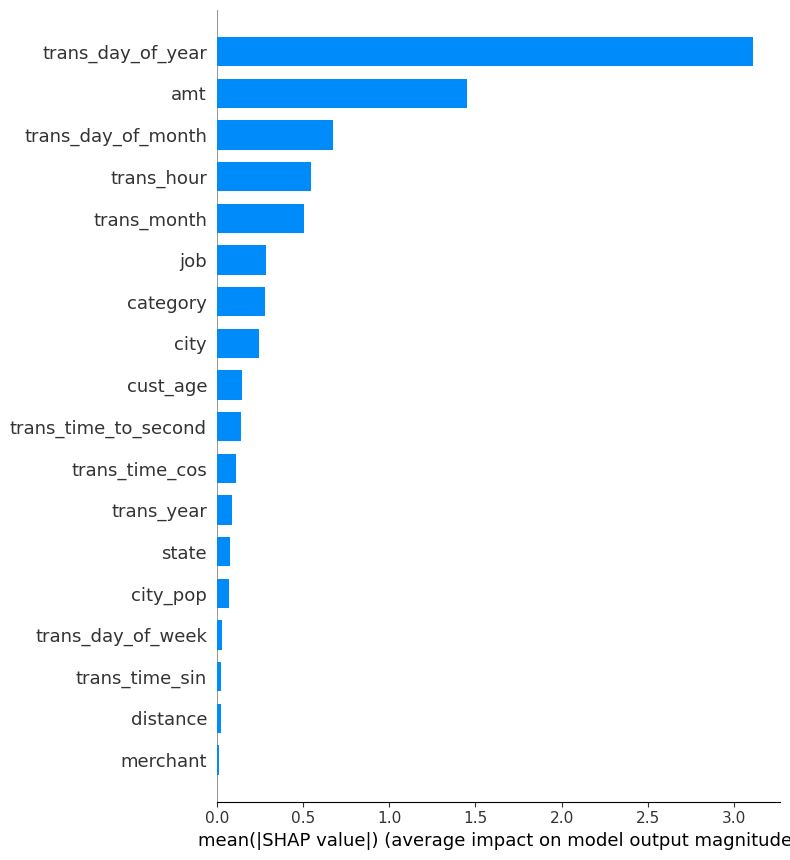

In [ ]:
# Membuat objek TreeExplainer untuk model XGBoost yang telah dilatih
explainer = shap.TreeExplainer(bst)

# Menghitung nilai SHAP untuk data uji, untuk melihat kontribusi setiap fitur terhadap prediksi
shap_values = explainer(test_DM)

# Membuat plot summary berupa bar plot untuk menunjukkan rata-rata pentingnya fitur dalam model
shap.summary_plot(shap_values, X_test, plot_type='bar')


### Experiment 2 (Best): Model XGBoost dengan Feature Selection SHAP Values

Pada eksperimen kedua ini, model XGBoost dilatih dengan fitur-fitur yang telah diseleksi berdasarkan nilai pentingnya (SHAP values) untuk menyederhanakan model sambil mempertahankan performa deteksi fraud yang optimal.

**Pemilihan Fitur Berdasarkan SHAP Values**  
Fitur-fitur yang digunakan dipilih berdasarkan kontribusi tertinggi dalam prediksi model. Dengan demikian, hanya fitur-fitur paling relevan yang digunakan, yaitu `trans_day_of_year`, `amt`, `trans_day_of_month`, `trans_hour`, `trans_month`, `job`, `category`, dan `city`. Model ini diharapkan dapat bekerja lebih efisien dengan mengabaikan fitur yang kurang penting.

**Parameter Model XGBoost**  
Model dikonfigurasi untuk klasifikasi biner, dengan `aucpr` sebagai metrik evaluasi utama untuk mengatasi ketidakseimbangan data. Pengaturan `eta` sebesar 0.01 tetap dipertahankan untuk menjaga stabilitas pembelajaran dan mencegah overfitting, serta `RANDOM_STATE` untuk konsistensi hasil.

**Hasil Cross-Validation**  
Cross-validation dilakukan dengan 5 fold untuk menilai performa model yang menggunakan fitur terbatas ini. Pada iterasi awal, `train_aucpr` mencapai 0.99106 dan `test_aucpr` berada di 0.98364, menunjukkan performa yang baik sejak awal. Setelah 500 iterasi, `train_aucpr` mencapai 1.0000, sedangkan `test_aucpr` mencapai 0.99940 pada iterasi terakhir (1549), yang sangat mendekati performa model full feature di eksperimen pertama.

**Training Model (Best Model)**  
Model dilatih dengan maksimum 100,000 iterasi, dan early stopping pada 100 iterasi tanpa peningkatan signifikan. Pada iterasi awal, `test_aucpr` mencapai 0.98552, sedikit lebih baik daripada model full feature (0.98364). Setelah 500 iterasi, `test_aucpr` mencapai 0.99883, yang hampir setara dengan performa model sebelumnya (0.99954), menunjukkan bahwa penyederhanaan fitur tidak berdampak besar pada performa akhir.

**Kesimpulan**  
Eksperimen ini menunjukkan bahwa model XGBoost dengan fitur terbatas yang dipilih berdasarkan nilai SHAP dapat mencapai performa yang hampir setara dengan model full feature. Meskipun terdapat sedikit penurunan pada nilai `test_aucpr` akhir (0.99883 vs. 0.99954), perbedaan ini tidak signifikan. Hal ini menunjukkan bahwa fitur tambahan tidak memberikan peningkatan performa yang berarti, dan penggunaan fitur yang terpilih melalui SHAP bisa menjadi alternatif yang lebih efisien, baik dalam hal waktu pemrosesan maupun kompleksitas model.


#### Pemilihan Fitur Berdasarkan SHAP Value Importances

Dalam kode ini, beberapa fitur dipilih berdasarkan **nilai pentingnya SHAP** yang telah dihitung sebelumnya. Fitur-fitur yang dipilih adalah fitur-fitur dengan kontribusi tertinggi terhadap prediksi model, seperti yang ditunjukkan dalam SHAP summary plot sebelumnya. Dengan menggunakan fitur-fitur terpilih ini, kita dapat menyederhanakan model tanpa mengurangi performa secara signifikan.

Langkah-langkah yang dilakukan:
- **selected_feature**: Daftar fitur yang dipilih, yang terdiri dari fitur-fitur dengan nilai SHAP tertinggi, yaitu `trans_day_of_year`, `amt`, `trans_day_of_month`, `trans_hour`, `trans_month`, `job`, `category`, dan `city`.
- **train_DM**: Mengonversi data latih menggunakan fitur terpilih menjadi DMatrix (`train_DM`), yang digunakan untuk cross-validation dan pelatihan model.
- **test_DM**: Mengonversi data uji menggunakan fitur terpilih menjadi DMatrix (`test_DM`), yang akan digunakan untuk evaluasi akhir model dan interpretasi nilai SHAP.

Dengan pemilihan fitur ini, diharapkan model dapat bekerja lebih efisien tanpa kehilangan akurasi, karena hanya menggunakan fitur yang paling relevan dalam mendeteksi fraud.


In [63]:
# Memilih fitur berdasarkan pentingnya SHAP value
selected_feature = ['trans_day_of_year', 'amt', 'trans_day_of_month', 'trans_hour', 'trans_month', 'job', 'category', 'city']

# Mengonversi data latih menjadi DMatrix (train_DM) dengan hanya fitur terpilih, untuk digunakan dalam cross-validation dan pelatihan model
train_DM = xgb.DMatrix(X_train[selected_feature], label=y_train, enable_categorical=True)

# Mengonversi data uji menjadi DMatrix (test_DM) dengan hanya fitur terpilih, untuk evaluasi akhir dan interpretasi SHAP value
test_DM = xgb.DMatrix(X_test[selected_feature], label=y_test, enable_categorical=True)

#### Parameter Model XGBoost

- **objective**: Menetapkan tujuan model sebagai `binary:logistic`, yang sesuai untuk klasifikasi biner dan mengembalikan probabilitas hasil kelas positif.
- **seed**: Menetapkan nilai `RANDOM_STATE` untuk menjaga konsistensi hasil dan memastikan eksperimen dapat diulang.
- **eval_metric**: Metrik evaluasi yang digunakan adalah `aucpr` (Area Under Precision-Recall Curve), metrik yang cocok digunakan pada data yang tidak seimbang untuk menilai trade-off antara presisi dan sensitivitas.
- **eta**: Learning rate yang diatur sebesar `0.01`, yang memperlambat laju pembelajaran guna menghindari overfitting dan memungkinkan model belajar pola secara bertahap.


In [64]:
# Parameter untuk model XGBoost
params = {
    'objective': 'binary:logistic',  # Menetapkan jenis model untuk klasifikasi biner dengan output probabilitas
    'seed': RANDOM_STATE,            # Menyediakan nilai random seed untuk reproduktifitas hasil
    'eval_metric': 'aucpr',          # Menggunakan AUC-PR (Area Under Precision-Recall Curve) sebagai metrik evaluasi, yang cocok untuk data tidak seimbang
    'eta': 0.01,                     # Learning rate untuk memperlambat proses pembelajaran model dan menghindari overfitting
}

#### Cross-Validation with XGBoost (Selected Features)

Pada eksperimen ini, dilakukan cross-validation (CV) menggunakan model XGBoost dengan **selected features** yang diperoleh dari analisis SHAP sebelumnya. Fitur yang digunakan merupakan fitur yang memiliki pengaruh terbesar terhadap prediksi, sehingga dapat menyederhanakan model tanpa mengurangi performa signifikan. Cross-validation digunakan untuk mengevaluasi stabilitas dan generalisasi model, dengan pengaturan berikut:

- **nfold=5**: Membagi data menjadi 5 lipatan (fold) untuk melakukan validasi silang.
- **num_boost_round=10,000**: Menetapkan jumlah maksimum iterasi (boosting rounds) hingga 10,000 putaran.
- **early_stopping_rounds=100**: Menghentikan pelatihan otomatis jika selama 100 putaran tidak ada peningkatan signifikan pada metrik evaluasi.
- **verbose_eval=500**: Menampilkan hasil evaluasi setiap 500 putaran.
- **stratified=True**: Membagi data secara terstratifikasi berdasarkan kelas target untuk menjaga distribusi kelas yang seimbang dalam setiap lipatan.

**Penjelasan Output**:
- Output menampilkan metrik `train_aucpr` dan `test_aucpr` pada berbagai titik evaluasi. `train_aucpr` menunjukkan performa model pada data latih, sedangkan `test_aucpr` menunjukkan performa pada data uji.
- Pada iterasi awal (`[0]`), `train_aucpr` mencapai 0.99106 dan `test_aucpr` berada di 0.98364, menunjukkan performa yang baik sejak awal pelatihan.
- Setelah 500 iterasi, `train_aucpr` mencapai 1.0000, menunjukkan model telah menyesuaikan data latih dengan sangat baik.
- `test_aucpr` meningkat hingga mencapai nilai tertinggi pada iterasi terakhir (`[1549]`) sebesar 0.99940, menunjukkan performa yang sangat baik pada data uji.

**Perbandingan dengan Model Sebelumnya**:
- Hasil ini menunjukkan bahwa model dengan fitur terbatas (selected features) mencapai performa yang hampir setara dengan model yang menggunakan semua fitur. `test_aucpr` model ini mencapai 0.99940, sedikit lebih rendah dibandingkan model sebelumnya yang mencapai 0.99954. Penurunan ini sangat kecil dan tidak signifikan, menunjukkan bahwa pengurangan fitur tidak banyak mengurangi performa.
- Bahkan, performa awal (`test_aucpr` di iterasi [0]) sedikit lebih baik di model ini (0.98364 dibandingkan 0.98395 pada model sebelumnya), yang bisa menandakan model yang lebih sederhana ini tetap efektif dalam mendeteksi pola pada data uji.
  
Dengan demikian, penggunaan **selected features** menghasilkan model yang lebih efisien tanpa mengorbankan akurasi signifikan. Hal ini menunjukkan bahwa variabel dengan nilai SHAP rendah dapat diabaikan tanpa kehilangan performa model yang berarti.


In [65]:
# Melakukan cross-validation (CV) dengan model XGBoost dan menampilkan metrik AUC-PR setiap 500 iterasi
score = xgb.cv(
    params,                  # Parameter model XGBoost
    train_DM,                # Data latih dalam format DMatrix
    nfold=5,                 # Cross-validation dengan 5 lipatan
    num_boost_round=10000,   # Jumlah maksimum boosting rounds adalah 10,000
    early_stopping_rounds=100,  # Penghentian awal jika tidak ada peningkatan selama 100 iterasi
    verbose_eval=500,        # Menampilkan hasil setiap 500 iterasi
    stratified=True          # Menggunakan stratifikasi untuk menjaga distribusi kelas di tiap lipatan
)

[0]	train-aucpr:0.99106+0.00154	test-aucpr:0.98364+0.01092
[500]	train-aucpr:1.00000+0.00000	test-aucpr:0.99853+0.00141
[1000]	train-aucpr:1.00000+0.00000	test-aucpr:0.99926+0.00084
[1500]	train-aucpr:1.00000+0.00000	test-aucpr:0.99939+0.00076
[1549]	train-aucpr:1.00000+0.00000	test-aucpr:0.99940+0.00076


#### Training Model XGBoost (Selected Features)

Model XGBoost dilatih menggunakan **selected features** yang telah dipilih berdasarkan nilai SHAP tertinggi. Model ini disebut sebagai **best model** karena dirancang untuk evaluasi di data uji dan interpretasi menggunakan SHAP untuk melihat pentingnya fitur yang relevan.

Pengaturan yang digunakan:
- **num_boost_round=100000**: Menetapkan jumlah maksimum boosting rounds hingga 100,000 putaran.
- **evals=[(test_DM, 'test')]**: Menetapkan data uji (`test_DM`) sebagai dataset evaluasi selama pelatihan, untuk memantau performa model pada data yang tidak dilatih.
- **early_stopping_rounds=100**: Menghentikan pelatihan secara otomatis jika tidak ada peningkatan dalam 100 iterasi pada metrik evaluasi, mencegah overfitting.
- **verbose_eval=500**: Menampilkan hasil evaluasi setiap 500 iterasi untuk memantau perkembangan performa model.

**Perbandingan dengan Model Full Feature**:
- Pada iterasi awal (`[0]`), `test_aucpr` mencapai 0.98552, sedikit lebih baik dibandingkan model full feature yang mencapai 0.98364, menunjukkan bahwa model dengan selected features memiliki performa awal yang cukup baik.
- Setelah 500 iterasi, `test_aucpr` mencapai 0.99883, yang sangat mendekati performa model full feature (0.99954). Ini menunjukkan bahwa meskipun ada sedikit penurunan performa akhir, model selected features tetap dapat mempertahankan akurasi yang tinggi dengan lebih sedikit fitur.

Kesimpulannya, menggunakan hanya fitur terpilih (selected features) memberikan performa yang hampir setara dengan model full feature, tetapi dengan kompleksitas yang lebih rendah. Ini menunjukkan bahwa fitur-fitur tambahan tidak memberikan peningkatan performa yang signifikan dan model dengan selected features bisa menjadi alternatif yang efisien.


In [66]:
# Melatih model XGBoost dengan hanya menggunakan selected features dan parameter yang telah ditentukan
bst = xgb.train(
    params,                  # Parameter model XGBoost
    train_DM,                # Data latih dalam format DMatrix dengan selected features
    num_boost_round=100000,  # Jumlah maksimum boosting rounds adalah 100,000
    evals=[(test_DM, 'test')],  # Menggunakan data uji sebagai evaluasi selama pelatihan
    early_stopping_rounds=100,  # Penghentian otomatis jika tidak ada peningkatan selama 100 iterasi
    verbose_eval=500          # Menampilkan hasil evaluasi setiap 500 iterasi
)

[0]	test-aucpr:0.98552
[500]	test-aucpr:0.99883
[501]	test-aucpr:0.99883


## Kesimpulan tentang Model Klasifikasi untuk Deteksi Penipuan Kartu Kredit

Dalam rangka membantu pekerja *frontline* dalam menilai penipuan kartu kredit, saya telah merancang model klasifikasi yang bertujuan untuk membedakan transaksi yang tergolong penipuan dan yang bukan penipuan. Model ini dirancang berdasarkan beberapa variabel kunci dan menggunakan metode klasifikasi yang andal. Berikut adalah poin-poin penting dari hasil analisis dan pengembangan model ini dalam menjawab pertanyaan terkait.

### 1. Variabel dan Metode Klasifikasi yang Digunakan
Pada model ini, digunakan 8 variabel dengan nilai SHAP value tertinggi dari keseluruhan variabel hasil fitur engineering. Variabel-variabel ini dipilih karena kontribusinya yang signifikan dalam mempengaruhi prediksi dan terdiri dari:
- **trans_day_of_year**: Hari dalam tahun transaksi.
- **amt**: Jumlah uang dalam transaksi.
- **trans_day_of_month**: Hari dalam bulan transaksi.
- **trans_hour**: Jam dalam hari transaksi.
- **trans_month**: Bulan transaksi.
- **job**: Pekerjaan pelanggan.
- **category**: Kategori merchant.
- **city**: Kota pelanggan.

Metode klasifikasi yang digunakan adalah *XGBoost*, yang dikenal memiliki performa tinggi dalam masalah klasifikasi terutama pada data yang tidak seimbang. Model ini dilatih dengan membagi data menjadi 80% untuk pelatihan dan 20% untuk pengujian terstratifikasi variabel y, memastikan kemampuan generalisasi pada data baru.

### 2. Evaluasi Kinerja Model Klasifikasi
Kinerja model dievaluasi menggunakan **confusion matrix** dan **classification report** untuk memberikan gambaran lengkap mengenai hasil prediksi:

#### Confusion Matrix:
\[
\begin{bmatrix}
2519 & 2 \\
9 & 347 \\
\end{bmatrix}
\]

- **True Negatives (TN)**: 2519 transaksi yang benar-benar bukan penipuan berhasil diklasifikasikan sebagai bukan penipuan.
- **False Positives (FP)**: 2 transaksi yang sebenarnya bukan penipuan diklasifikasikan sebagai penipuan.
- **False Negatives (FN)**: 9 transaksi yang sebenarnya adalah penipuan diklasifikasikan sebagai bukan penipuan.
- **True Positives (TP)**: 347 transaksi yang benar-benar penipuan berhasil diklasifikasikan sebagai penipuan.

#### Classification Report:
|               | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **Class 0** (Bukan Penipuan) | 1.00      | 1.00   | 1.00     | 2521    |
| **Class 1** (Penipuan)       | 0.99      | 0.97   | 0.98     | 356     |
| **Accuracy**                 | -         | -      | 1.00     | 2877    |
| **Macro Average**            | 1.00      | 0.99   | 0.99     | 2877    |
| **Weighted Average**         | 1.00      | 1.00   | 1.00     | 2877    |

Dari hasil classification report:
- **Precision** untuk kelas penipuan (0.99) menunjukkan bahwa model jarang salah dalam mendeteksi transaksi yang benar-benar penipuan.
- **Recall** untuk kelas penipuan (0.97) mengindikasikan bahwa model berhasil mendeteksi sebagian besar kasus penipuan, meskipun ada beberapa kasus yang terlewat.
- **F1-Score** mendekati nilai sempurna untuk kedua kelas, menunjukkan keseimbangan yang baik antara precision dan recall.
- **Accuracy** keseluruhan mendekati 1.00, menunjukkan kinerja model yang sangat baik.

### 3. Aplikasi Model untuk Pekerja Frontline
Model klasifikasi ini dapat diterapkan untuk membantu pekerja *frontline* dalam membuat keputusan yang lebih cepat dan akurat. Dengan adanya prediksi dari model ini, pekerja dapat:
- Menandai transaksi yang berisiko tinggi untuk diperiksa lebih lanjut.
- Mengurangi waktu analisis manual, karena model dapat mengelompokkan transaksi yang aman dan yang mencurigakan.

Model ini direncanakan untuk di-*deploy* di web, memungkinkan pekerja *frontline* untuk mengakses prediksi secara mudah dan real-time. Dengan implementasi berbasis web, pekerja dapat memeriksa prediksi model kapan pun diperlukan tanpa harus mengakses sistem yang kompleks, sehingga mendukung kemudahan penggunaan dan efisiensi waktu.

Secara keseluruhan, model ini dapat menjadi alat bantu yang sangat bermanfaat bagi pekerja *frontline* untuk melakukan penilaian penipuan dengan lebih terukur, konsisten, dan berdasarkan data, sehingga pengambilan keputusan dapat dilakukan dengan lebih baik dan cepat.

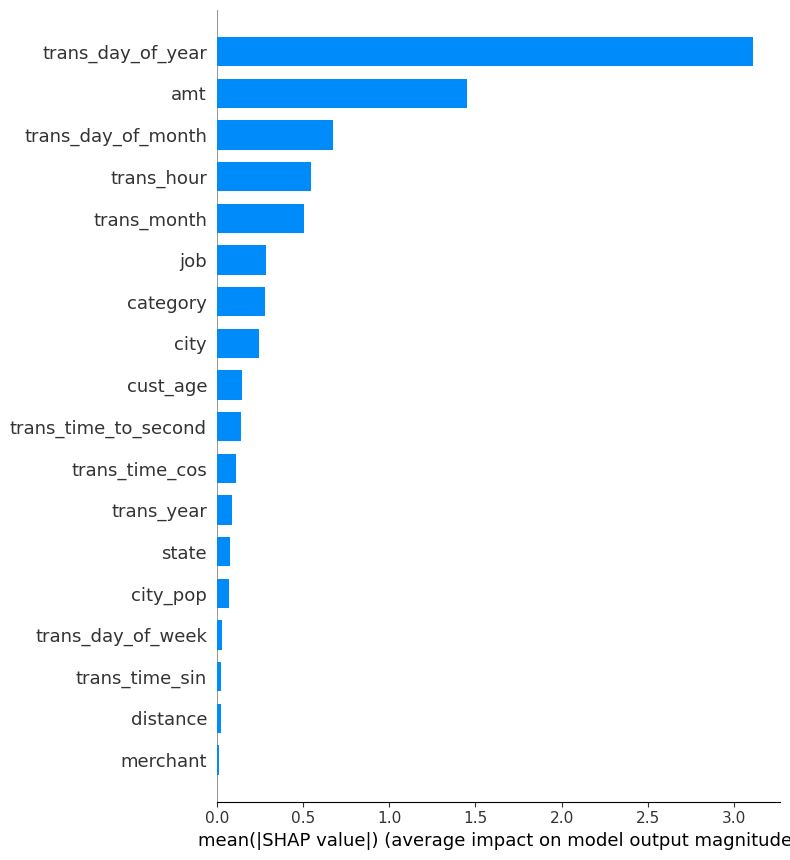

In [ ]:
# Membuat plot summary berupa bar plot untuk menunjukkan rata-rata pentingnya fitur dalam model
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [77]:
print('Confussion Matrix:')
print(confusion_matrix(y_test.astype(int), (bst.predict(test_DM) > 0.5).astype(int)))
print('\n\nClassification Report:')
print(classification_report(y_test.astype(int), (bst.predict(test_DM) > 0.5).astype(int)))

Confussion Matrix:
[[2519    2]
 [   9  347]]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2521
           1       0.99      0.97      0.98       356

    accuracy                           1.00      2877
   macro avg       1.00      0.99      0.99      2877
weighted avg       1.00      1.00      1.00      2877

